# System Identification - GFX

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise $w(t)$ is a Wiener process, with the parameter $\gamma$ representing precision. Measurement noise $e(t)$ is also Wiener, with $\xi$ as precision.

### Forecasting experiment

In this notebook, we will perform a forecasting experiment. The time-series will be split into a training and a validation part. In the training part, we will provide both input and output, and then infer parameters. In the forecasting part, we will only provide input. The parameters will be fixed to their inferred values and we will let the model make predictions for the output. Those predictions are evaluated against the true output.

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames
using Plots
viz = false;

In [2]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [3]:
# Select training set
trn = collect(41001:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn);

# Select validation set
val = 101:40100
input_val = input[val]
output_val = output[val]
T_val = length(val);

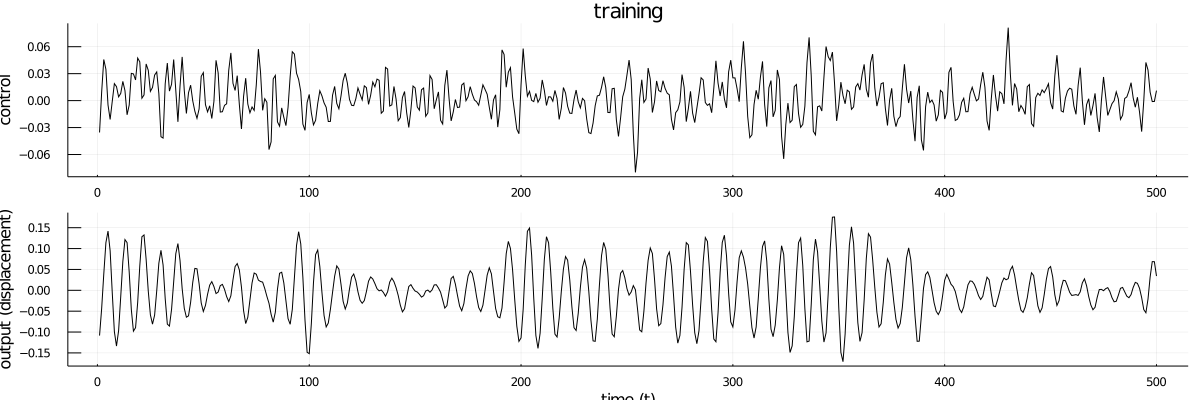

In [4]:
# Plot every n-th time-point to avoid figure size exploding
n = 1
T_trn = 500

p1a = Plots.plot(1:n:T_trn, input_trn[1:n:T_trn], color="black", label="", markersize=2, xlabel="", ylabel="control", size=(1200,400), title="training")    
p1b = Plots.plot(1:n:T_trn, output_trn[1:n:T_trn], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
p1 = plot(p1a, p1b, layout=(2,1))
# savefig(p1, "viz/training_set.png")

In [5]:
if viz
    p2a = Plots.plot(1:n:T_val, input_val[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="control", size=(1200,400), title="validation")    
    p2b = Plots.plot(1:n:T_val, output_val[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
    p2 = plot(p2a, p2b, layout=(2,1))
#     Plots.savefig(p2, "viz/validation_set.png")
end

## Solution steps

In this notebook we are tackling the system with a black-box model, ignoring the physical parameters altogether.

### 1. GFX model

GFX stands for Generalised Filtering with eXogenous input. It is described by the following equations:

$$\begin{align*}
    z_t =&\ A(\theta) z_{t-1} + B(\eta) u_t + w_t \\
    y_t =&\ c^{\top} z_t + v_t
\end{align*}$$

where $z_{t} = [x_t, x'_t, x''_t, \dots]^{\top}$ is the vector of generalised coordinates and $c$ is a masking vector only allowing you to observe the first entry of $z_t$ (i.e. no derivatives). $A(\theta)$ is a function that maps a vector of coefficients into a transition matrix:

$$\begin{bmatrix} 1 & \Delta t & 0 & \dots & 0\\ 
                  0 & 1 & \Delta t & 0 & \vdots \\ 
                  \vdots & 0 & \ddots & \ddots & \vdots \\ 
                  \vdots & \vdots & \vdots & \ddots & \Delta t\\ 
                  \theta_1 \Delta t & \theta_2 \Delta t & \dots & \dots & \theta_{M} \Delta t + 1\end{bmatrix} \, ,$$
  
which can be constructed from a matrix $S$, consisting of an identity matrix with its upper first off-diagonal having value $\Delta t$, and a vector out-product $s \theta^{
\top}$, where $s = [0;\ \dots;\ \Delta t]$ and $\theta = [\theta_1;\ \dots;\ \theta_M]^{\top}$. $B(\eta)$ is a vector of $[0,\ \dots, \ \eta  \Delta t]^{\top}$.

### 2. Convert to Gaussian probability

Integrating out $w_t$ and $e_t$ produces a Gaussian state transition node and a Gaussian likelihood node:

$$\begin{align*}
z_t \sim&\ \mathcal{N}(A(\theta) z_{t-1} + B(\eta)u_t, W^{-1}) \\
y_t \sim&\ \mathcal{N}(c^{\top} z_t, \xi^{-1}) \, .
\end{align*}$$

The state transition's precision matrix $W$ is a diagonal matrix with the final entry being $\gamma / \Delta t$. The other diagonal entries are either $1/\epsilon$ (for noise injections on the variable substitutions) or free parameters.


### 3. Choose priors

We currently have unknown parameters $\theta$, $\eta$, $\gamma$ and $\xi$. The coefficients can actually only be both positive, but we will use Gaussian priors nonetheless. The priors for the precision parameters $\gamma$ and $\xi$ will be Gamma distributions.

$$\begin{align*}
p(\theta) =&\ \text{Normal}(\theta \mid m^{0}_{\theta}, V^{0}_{\theta}) \\
p(\eta) =&\ \text{Normal}(\eta \mid m^{0}_{\eta}, V^{0}_{\eta}) \\
p(\gamma) =&\ \text{Gamma}(\gamma \mid a^{0}_\gamma, b^{0}_\gamma) \\
p(\xi) =&\ \text{Gamma}(\xi \mid a^{0}_\xi, b^{0}_\xi) 
\end{align*}$$

All priors are conjugate to the Gaussian nodes. We will start with a Gaussian prior $p(z_0) = \mathcal{N}(z_0 \mid 0.0, 1.0)$.

### 4. Recognition model

The recognition model will match the priors:

$$\begin{align*}
q(\theta) =&\ \text{Normal}(\theta \mid m_{\theta}, W_{\theta}^{-1}) \\
q(\eta) =&\ \text{Normal}(\eta \mid m_{\eta}, W_{\eta}^{-1}) \\
q(\gamma) =&\ \text{Gamma}(\gamma \mid a_\gamma, b_\gamma) \\
q(\xi) =&\ \text{Gamma}(\xi \mid a_\xi, b_\xi) 
\end{align*}$$

If the generative and recognition model match, the recognition model's approximation error can potentially reach $0$. We will also have a recognition distribution for each state:

$$\begin{align*}
q(z_t) = \mathcal{N}(z_t \mid m_{z_t}, W^{-1}_{z_t}) \quad \text{for}\ t = 0, 1, \dots, T \, .
\end{align*}$$

This is thus a mean-field factorization. In the future, we might want to adopt a structured factorization, i.e. recognition distributions of the form $q(z_t, z_{t-1})$. 

## Implementation

We implement this model with the toolbox ForneyLab.jl and a custom GFX node.

In [6]:
using LinearAlgebra
using ProgressMeter
using ForneyLab

import ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision

In [39]:
using GFX

In [40]:
# Start graph
graph = FactorGraph()

# Sampling time
Δt = 1/610.35
# Δt = 1.

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:W_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Exogenous input
@RV u_t 

# State prior
@RV z_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), 
                                    placeholder(:W_z, dims=(2, 2)), id=:z_tmin1)

# State transition
@RV z_t ~ GeneralisedFilterX(θ, z_tmin1, η, u_t, γ, Δt=Δt)

# Observation likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1., 0.], z_t), ξ, id=:y_t)

# Denote observed variables
placeholder(y_t, :y_t)
placeholder(u_t, :u_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

# Infer an algorithm
q = PosteriorFactorization(z_t, z_tmin1, θ, η, γ, ξ, ids=[:z :ztmin1 :θ :η :γ :ξ])
algo = messagePassingAlgorithm()
source_code = algorithmSourceCode(algo)
eval(Meta.parse(source_code));
# println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 7395029506436597687 -->
 
 7395029506436597687 
 
 placeholder_a_γ 
 
<!-- 18284977126261111828 -->
 
 18284977126261111828 
 
 placeholder_m_z 
 
<!-- 5524380532282118434 -->
 
 5524380532282118434 
 
 clamp_1 
 
<!-- 10906366401575192161 -->
 
 10906366401575192161 
 
 placeholder_w_η 
 
<!-- 5013052344604199928 -->
 
 5013052344604199928 
 
 placeholder_a_ξ 
 
<!-- 6075985364207638654 -->
 
 6075985364207638654 
 
 placeholder_W_z 
 
<!-- 16165357730798409312 -->
 
 16165357730798409312 
 
 𝒩 
 z_tmin1 
 
<!-- 16165357730798409312--18284977126261111828 -->
 
 16165357730798409312--18284977126261111828 
 
 m_z 
 1 out 
 2 m 
 
<!-- 16165357730798409312--6075985364207638654 -->
 
 16165357730798409312--6075985364207638654 
 
 W_z 
 1 out 
 3 w 
 
<!-- 9836718018424394582 -->
 
 9836718018424394582 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 9836718018424394582--10906366401575192161 -->
 
 9836718018424394582--10906366401575192161 
 
 w_η 
 1 out 
 3 w 
 
<!-- 18104499458630669513 -->
 
 18104499458630669513 
 
 placeholder_m_η 
 
<!-- 9836718018424394582--18104499458630669513 -->
 
 9836718018424394582--18104499458630669513 
 
 m_η 
 1 out 
 2 m 
 
<!-- 12799813264373892852 -->
 
 12799813264373892852 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 7592463174531147663 -->
 
 7592463174531147663 
 
 placeholder_W_θ 
 
<!-- 12799813264373892852--7592463174531147663 -->
 
 12799813264373892852--7592463174531147663 
 
 W_θ 
 1 out 
 3 w 
 
<!-- 8113455648515016221 -->
 
 8113455648515016221 
 
 placeholder_m_θ 
 
<!-- 12799813264373892852--8113455648515016221 -->
 
 12799813264373892852--8113455648515016221 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 6842310680610655267 -->
 
 6842310680610655267 
 
 𝒩 
 y_t 
 
<!-- 10839613365204767452 -->
 
 10839613365204767452 
 
 dot 
 dotproduct_1 
 
<!-- 6842310680610655267--10839613365204767452 -->
 
 6842310680610655267--10839613365204767452 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 6703960704384591575 -->
 
 6703960704384591575 
 
 Gam 
 gamma_2 
 
<!-- 6842310680610655267--6703960704384591575 -->
 
 6842310680610655267--6703960704384591575 
 
 ξ 
 1 out 
 3 w 
 
<!-- 16446904540612390010 -->
 
 16446904540612390010 
 
 placeholder_y_t 
 
<!-- 16446904540612390010--6842310680610655267 -->
 
 16446904540612390010--6842310680610655267 
 
 y_t 
 1 out 
 1 out 
 
<!-- 15604313945523025537 -->
 
 15604313945523025537 
 
 placeholder_u_t 
 
<!-- 15153518024674482688 -->
 
 15153518024674482688 
 
 GFX 
 generalisedfilterx_1 
 
<!-- 15604313945523025537--15153518024674482688 -->
 
 15604313945523025537--15153518024674482688 
 
 u_t 
 5 u 
 1 out 
 
<!-- 10839613365204767452--5524380532282118434 -->
 
 10839613365204767452--5524380532282118434 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 10839613365204767452--15153518024674482688 -->
 
 10839613365204767452--15153518024674482688 
 
 z_t 
 1 y 
 2 in1 
 
<!-- 15153518024674482688--16165357730798409312 -->
 
 15153518024674482688--16165357730798409312 
 
 z_tmin1 
 1 out 
 3 x 
 
<!-- 15153518024674482688--9836718018424394582 -->
 
 15153518024674482688--9836718018424394582 
 
 η 
 1 out 
 4 η 
 
<!-- 15153518024674482688--12799813264373892852 -->
 
 15153518024674482688--12799813264373892852 
 
 θ 
 1 out 
 2 θ 
 
<!-- 11948508799109368863 -->
 
 11948508799109368863 
 
 Gam 
 gamma_1 
 
<!-- 15153518024674482688--11948508799109368863 -->
 
 15153518024674482688--11948508799109368863 
 
 γ 
 1 out 
 6 γ 
 
<!-- 14992081009473458956 -->
 
 14992081009473458956 
 
 placeholder_b_ξ 
 
<!-- 12450899415030537220 -->
 
 12450899415030537220 
 
 placeholder_b_γ 
 
<!-- 6703960704384591575--5013052344604199928 -->
 
 6703960704384591575--5013052344604199928 
 
 a_ξ 
 1 out 
 2 a 
 
<!-- 6703960704384591575--14992081009473458956 -->
 
 67

### Infer parameters

In [56]:
T_trn = 500

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_z = (zeros(2, T_trn+1), repeat(1. .*float(eye(2)), outer=(1,1,T_trn+1)))
params_θ = (0.5  .*rand(2, T_trn+1), repeat(1. .*float(eye(2)), outer=(1,1,T_trn+1)))
params_η = (1.0  .*ones(1, T_trn+1), 1.0 .*ones(1, T_trn+1))
params_γ = (1e-1 .*ones(1, T_trn+1), 1e-2 .*ones(1, T_trn+1))
params_ξ = (1.0 .*ones(1, T_trn+1), 1.0 .*ones(1, T_trn+1))

# Perform inference at each time-step
@showprogress for t = 1:T_trn

    # Initialize marginals
    marginals[:z_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t], w=params_z[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t], w=params_z[2][:,:,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t], b=params_ξ[2][1,t])
    
    data = Dict(:y_t => output_trn[t],
                :u_t => input_trn[t],
                :m_z => params_z[1][:,t],
                :W_z => params_z[2][:,:,t],
                :m_θ => params_θ[1][:,t],
                :W_θ => params_θ[2][:,:,t],
                :m_η => params_η[1][1,t],
                :w_η => params_η[2][1,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t],
                :a_ξ => params_ξ[1][1,t],
                :b_ξ => params_ξ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepz!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepγ!(data, marginals)
        stepξ!(data, marginals)
        stepztmin1!(data, marginals)
        
    end

    # Store current parameterizations of marginals
    params_z[1][:,t+1] = unsafeMean(marginals[:z_t])
    params_z[2][:,:,t+1] = marginals[:z_t].params[:w]
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[1][1,t+1] = unsafeMean(marginals[:η])
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]
    params_ξ[1][1,t+1] = marginals[:ξ].params[:a]
    params_ξ[2][1,t+1] = marginals[:ξ].params[:b]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


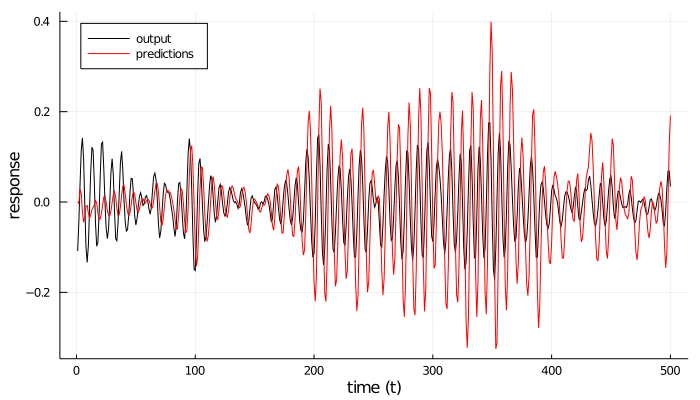

In [60]:
# Estimated states
estimated_states = params_z[1][1,:]

# Plot every n-th time-point to avoid figure size exploding
n = 1

p3 = plot(1:n:T_trn, output_trn[1:n:T_trn], color="black", label="output", markersize=2, xlabel="time (t)", ylabel="response", legend=:topleft)
plot!(1:n:T_trn, 1e6*estimated_states[1:n:T_trn], color="red", linewidth=1, label="predictions", size=(700,400))
# plot(1:n:T_trn, estimated_states[1:n:T_trn], color="red", linewidth=1, label="predictions", size=(700,400))

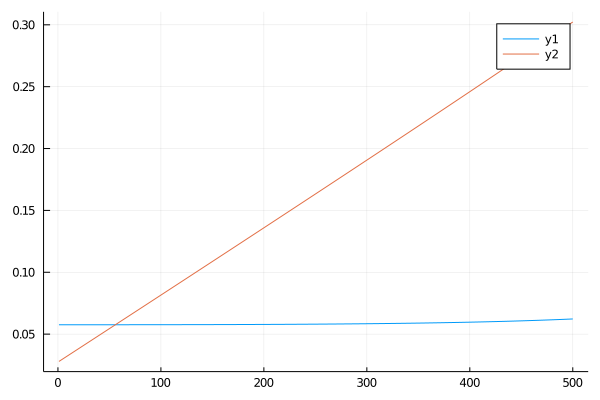

In [43]:
plot(1:T_trn, params_θ[1][:,2:end]')

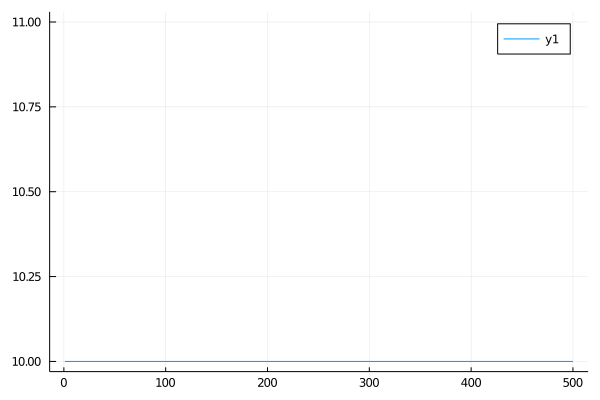

In [28]:
mγ = params_γ[1] ./ params_γ[2]
plot(1:T_trn, mγ[2:end])

## Simulation error on validation data

In [ ]:
# Start graph
graph2 = FactorGraph()

# Clamped variables
@RV z_tmin1
@RV θ
@RV η
@RV u_t
@RV γ

# State transition
@RV z_pred_t ~ GeneralisedFilterX(θ, z_tmin1, η, u_t, γ, Δt=Δt)

# Indicate observed variables
placeholder(θ, :θ, dims=(2,))
placeholder(z_tmin1, :z_tmin1, dims=(2,))
placeholder(η, :η)
placeholder(u_t, :u_t)
placeholder(γ, :γ)

# Draw time-slice subgraph
ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(z_pred_t, ids=[:z_pred_t])
algo2 = messagePassingAlgorithm(z_pred_t, q2, free_energy=false)
source_code2 = algorithmSourceCode(algo2, free_energy=false)
eval(Meta.parse(source_code2));
# println(source_code2)

In [ ]:
# Fix estimates of coefficients and precision
mθ = params_θ[1][:,end]
mη = params_η[1][1,end]
mγ = params_γ[1][1,end]/params_γ[2][1,end]
mξ = params_ξ[1][1,end]/params_ξ[2][1,end]

# Initialize arrays of parameterizations
params_z_pred = (zeros(2, T_val), repeat(0.001 .*float(eye(2)), outer=(1,1,T_val)))

# Set first 
params_z_pred[1][1,1] = output_val[1]
params_z_pred[2][1,1,1] = 1e4

# Perform inference at each time-step
@showprogress for t = 2:T_val
    
    "Filtering"

    # Initialize marginals
    marginals[:z_pred_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z_pred[1][:,t-1], w=params_z_pred[2][:,:,t-1])
    
    # Set clamped variables
    data = Dict(:u_t => input_val[t],
                :z_tmin1 => params_z_pred[1][:,t-1],
                :θ => mθ,
                :η => mη,
                :γ => mγ,
                :ξ => mξ)
        
    # Update output prediction
    stepz_pred_t!(data, marginals)

    # Store current parameterizations of marginals
    params_z_pred[1][:,t] = unsafeMean(marginals[:z_t])
    params_z_pred[2][:,:,t] = marginals[:z_t].params[:w]

end

In [ ]:
# Extract mean of state marginals
predictions = params_z_pred[1][1,:]

# Plot every n-th time-point to avoid figure size exploding
n = 10

p3 = Plots.scatter(1:n:T_val, output_val[1:n:T_val], color="black", label="output", markersize=2, xlabel="time (t)", ylabel="response", legend=:topleft)
Plots.plot!(1:n:T_val, predictions[1:n:T_val], color="red", linewidth=1, label="predictions", size=(700,400))

In [ ]:
Plots.savefig(p3, "viz/forecasts.png")

In [ ]:
# Error plot
sim_error = (predictions .- output_val).^2
p3b = Plots.scatter(1:n:T_val, 
                   sim_error[1:n:end], 
                   color="black", 
                   label="", 
                   markersize=2, 
                   size=(700,400), 
                   xlabel="time (t)", 
                   ylabel="prediction error",
                   labels="MSE = "*string(mean(sim_error)),
                   yscale=:log10,
                   ylims=[1e-12, maximum(sim_error)],
                   title="GFX - Simulation error")

In [ ]:
Plots.savefig(p3b, "viz/GFX_sim-error.png")

In [ ]:
println("MSE = "*string(mean(sim_error)))

## 1-step ahead prediction error

In [ ]:
# Fix estimates of coefficients and precision
mθ = params_θ[1][:,end]
mγ = params_γ[1][1,end]/params_γ[2][1,end]

# Initialize arrays of parameterizations
params_y = (zeros(1,T_val), zeros(1,T_val))

# Start progress bar
p = Progress(T_val, 1, "At time ")

# Perform inference at each time-step
for t = max(M,N)+1:T_val

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:y_t] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_y[1][:,t-1], w=params_y[2][1,t-1])
    
    # Update input, output vectors
    x_t = output_val[t-1:-1:t-M]
    z_t = input_val[t-1:-1:t-N]
    
    # Set clamped variables
    data = Dict(:u_t => input_val[t],
                :x_t => x_t,
                :z_t => z_t,
                :θ => mθ,
                :γ => mγ)

    # Iterate variational parameter updates
    for i = 1:num_iterations
        
        # Update output prediction
        stepy!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_y[1][1,t] = unsafeMean(marginals[:y_t])
    params_y[2][1,t] = marginals[:y_t].params[:w]

end

In [ ]:
# Extract mean of state marginals
predictions = params_y[1][1,:]

# Plot every n-th time-point to avoid figure size exploding
n = 10

p3 = Plots.scatter(1:n:T_val, output_val[1:n:T_val], color="black", label="output", markersize=2, xlabel="time (t)", ylabel="response", legend=:topleft)
Plots.plot!(1:n:T_val, predictions[1:n:T_val], color="red", linewidth=1, label="predictions", size=(700,400))

In [ ]:
# Error plot
pred_error = (predictions .- output_val).^2
p4 = Plots.scatter(1:n:T_val, 
                   pred_error[1:n:end], 
                   color="black", 
                   label="", 
                   markersize=2, 
                   size=(700,400), 
                   xlabel="time (t)", 
                   ylabel="prediction error",
                   labels="MSE = "*string(mean(pred_error)),
                   yscale=:log10,
                   ylims=[1e-12, 1e-2],
                   title="NARX3 - 1-step ahead prediction error")

In [ ]:
Plots.savefig(p4, "viz/NARX3_pred-error.png")

In [ ]:
println("MSE = "*string(mean(pred_error)))

### Baseline: neural network

We have implemented a neural network in Matlab as a baseline method.

In [ ]:
using MAT
results = matread("../sota-baselines/training_results.mat")

In [ ]:
# Error plot
p5 = Plots.scatter(3:n:T_val, 
                   results["error"][3:n:end], 
                   color="black", 
                   label="", 
                   markersize=2, 
                   size=(700,400), 
                   yscale=:log10,
                   xlabel="time (t)", 
                   ylabel="prediction error",
                   labels="MSE = "*string(mean(results["error"])),
                   title="NN-4 - Prediction errors over time")

In [ ]:
Plots.savefig(p5, "viz/NN4_pred-error.png")

In [ ]:
println("MSE = "*string(mean(results["error"])))

## Visualize parameter estimates

In [ ]:
# Extract mean of state marginals
coefficients = params_θ[1]

# Plot every n-th time-point to avoid figure size exploding
n = 10

Plots.plot(1:n:T_trn, coefficients[:,1:n:T_trn]', linewidth=1, label="predictions", size=(700,400))

In [ ]:
M = 1

# Extract parameters of final coefficients for the history of observations
mθ_x = zeros(T_trn, 3*M)
sθ_x = zeros(T_trn, 3*M)
for k = 1:(3*M)
    mθ_x[:,k] = params_θ[1][k, 2:end]
    sθ_x[:,k] = sqrt.(inv.(params_θ[2][k,k, 2:end]))
end

# Labels
labels = ["θ_{x_1}^3" "θ_{x_2}^3" "θ_{x_3}^3" "θ_{x_1}^2" "θ_{x_2}^2" "θ_{x_3}^2" "θ_{x_1}^1" "θ_{x_2}^1" "θ_{x_3}^1"]

if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 50
    
    # Plot evolution of coefficients
    p5 = Plots.plot(1:n:T_trn, 
                    mθ_x[1:n:T_trn,:], 
                    ribbon=[sθ_x[1:n:T_trn,:], sθ_x[1:n:T_trn,:]], 
                    linewidth=3, 
                    labels=labels, 
                    xlabel="time (t)", 
                    ylabel="Parameter estimate", 
                    title="Estimated θ for states x",
                    legend=:topright, 
                    ylims=[-2.2, 4.8])
end

In [ ]:
Plots.savefig(p5, "viz/coefficient_estimates_x.png")

In [ ]:
# Extract parameters of final precision posteriors
mγ = params_γ[1][1,2:end] ./ params_γ[2][1,2:end]
sγ = sqrt.(params_γ[1][1,2:end] ./ params_γ[2][1,2:end].^2)

if viz
    # Plot evolution of precision parameter
#     p8 = Plots.plot(1:n:T_trn, mγ[1:n:T_trn], ribbon=[sγ[1:n:T_trn], sγ[1:n:T_trn]], label="γ", xlabel="time (t)", linewidth=3, size=(600,400), xscale=:log10, legend=:topleft)
    p8 = Plots.plot(1:n:T_trn, 
                    mγ[1:n:T_trn], 
                    label="γ", 
                    xlabel="time (t)", 
                    ylabel="Parameter estimate", 
                    linewidth=3, 
                    size=(600,400), 
                    xscale=:log10, 
                    yscale=:log10, 
                    legend=:topleft)
end

In [ ]:
Plots.savefig(p8, "viz/precision_estimates.png")